Hypothesis: We might be representation bottlenecked and that might be contributing to our less than ideal performance. What if we start by pretraining our network to do autoencoding, chop off the decoder, and then do our metric learning on that

In [1]:
import transformer_lens
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm

import random

In [2]:
seed = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [3]:
# Load datasets
train_set = load_dataset("sentence-transformers/stsb", split="train")
val_set   = load_dataset("sentence-transformers/stsb", split="validation")
test_set  = load_dataset("sentence-transformers/stsb", split="test")

first_train  = torch.load('gpt2_medium_train_acts_1.npy')
second_train = torch.load('gpt2_medium_train_acts_2.npy')

first_test = torch.load('gpt2_medium_test_acts_1.npy')
second_test = torch.load('gpt2_medium_test_acts_2.npy')

wikitext_acts = torch.load('generics_kb_20k_10312024.npy')

train_scores = torch.Tensor(train_set['score'])
test_scores = torch.Tensor(test_set['score'])

  4%|███████                                                                                                                                                                        | 10/250 [02:09<52:20, 13.08s/it]


Epoch 10
Train Losses - Early: 0.301, Mid: 1.289, Late: 10.822
Test Losses  - Early: 1.417, Mid: 5.092, Late: 26.179


  8%|██████████████                                                                                                                                                                 | 20/250 [04:14<48:13, 12.58s/it]


Epoch 20
Train Losses - Early: 0.249, Mid: 1.065, Late: 8.316
Test Losses  - Early: 1.315, Mid: 4.639, Late: 21.923


 12%|█████████████████████                                                                                                                                                          | 30/250 [06:19<45:38, 12.45s/it]


Epoch 30
Train Losses - Early: 0.220, Mid: 0.959, Late: 7.450
Test Losses  - Early: 1.274, Mid: 4.444, Late: 20.402


 16%|████████████████████████████                                                                                                                                                   | 40/250 [08:22<43:01, 12.29s/it]


Epoch 40
Train Losses - Early: 0.199, Mid: 0.888, Late: 6.928
Test Losses  - Early: 1.252, Mid: 4.341, Late: 19.845


 20%|███████████████████████████████████                                                                                                                                            | 50/250 [10:25<41:00, 12.30s/it]


Epoch 50
Train Losses - Early: 0.185, Mid: 0.834, Late: 6.564
Test Losses  - Early: 1.240, Mid: 4.303, Late: 19.632


 24%|██████████████████████████████████████████                                                                                                                                     | 60/250 [12:28<39:01, 12.32s/it]


Epoch 60
Train Losses - Early: 0.175, Mid: 0.793, Late: 6.275
Test Losses  - Early: 1.239, Mid: 4.264, Late: 19.521


 28%|█████████████████████████████████████████████████                                                                                                                              | 70/250 [14:31<36:58, 12.32s/it]


Epoch 70
Train Losses - Early: 0.167, Mid: 0.761, Late: 6.050
Test Losses  - Early: 1.246, Mid: 4.224, Late: 19.387


 32%|████████████████████████████████████████████████████████                                                                                                                       | 80/250 [16:37<36:08, 12.75s/it]


Epoch 80
Train Losses - Early: 0.160, Mid: 0.737, Late: 5.867
Test Losses  - Early: 1.246, Mid: 4.210, Late: 19.169


 36%|███████████████████████████████████████████████████████████████                                                                                                                | 90/250 [18:43<33:09, 12.43s/it]


Epoch 90
Train Losses - Early: 0.155, Mid: 0.717, Late: 5.709
Test Losses  - Early: 1.257, Mid: 4.199, Late: 19.483


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 100/250 [20:46<30:53, 12.36s/it]


Epoch 100
Train Losses - Early: 0.151, Mid: 0.701, Late: 5.567
Test Losses  - Early: 1.262, Mid: 4.200, Late: 19.228


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 110/250 [22:49<28:42, 12.31s/it]


Epoch 110
Train Losses - Early: 0.147, Mid: 0.687, Late: 5.450
Test Losses  - Early: 1.264, Mid: 4.169, Late: 19.229


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 120/250 [24:52<26:43, 12.33s/it]


Epoch 120
Train Losses - Early: 0.144, Mid: 0.675, Late: 5.343
Test Losses  - Early: 1.273, Mid: 4.165, Late: 19.110


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 130/250 [26:56<24:47, 12.39s/it]


Epoch 130
Train Losses - Early: 0.141, Mid: 0.665, Late: 5.245
Test Losses  - Early: 1.272, Mid: 4.168, Late: 19.221


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 140/250 [29:00<22:41, 12.38s/it]


Epoch 140
Train Losses - Early: 0.139, Mid: 0.656, Late: 5.161
Test Losses  - Early: 1.275, Mid: 4.152, Late: 19.316


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 150/250 [31:02<20:27, 12.27s/it]


Epoch 150
Train Losses - Early: 0.136, Mid: 0.649, Late: 5.085
Test Losses  - Early: 1.285, Mid: 4.128, Late: 19.399


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 160/250 [33:06<18:29, 12.32s/it]


Epoch 160
Train Losses - Early: 0.134, Mid: 0.642, Late: 5.016
Test Losses  - Early: 1.289, Mid: 4.096, Late: 19.125


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 170/250 [35:09<16:23, 12.29s/it]


Epoch 170
Train Losses - Early: 0.133, Mid: 0.637, Late: 4.954
Test Losses  - Early: 1.280, Mid: 4.103, Late: 19.240


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 180/250 [37:11<14:22, 12.31s/it]


Epoch 180
Train Losses - Early: 0.131, Mid: 0.631, Late: 4.890
Test Losses  - Early: 1.292, Mid: 4.078, Late: 19.513


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 190/250 [39:14<12:18, 12.31s/it]


Epoch 190
Train Losses - Early: 0.130, Mid: 0.626, Late: 4.846
Test Losses  - Early: 1.287, Mid: 4.096, Late: 19.320


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 200/250 [41:17<10:13, 12.27s/it]


Epoch 200
Train Losses - Early: 0.129, Mid: 0.622, Late: 4.794
Test Losses  - Early: 1.288, Mid: 4.089, Late: 19.433


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 210/250 [43:20<08:12, 12.31s/it]


Epoch 210
Train Losses - Early: 0.127, Mid: 0.617, Late: 4.742
Test Losses  - Early: 1.286, Mid: 4.065, Late: 19.532


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 220/250 [45:23<06:10, 12.34s/it]


Epoch 220
Train Losses - Early: 0.126, Mid: 0.614, Late: 4.703
Test Losses  - Early: 1.284, Mid: 4.064, Late: 19.630


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 230/250 [47:26<04:06, 12.30s/it]


Epoch 230
Train Losses - Early: 0.125, Mid: 0.610, Late: 4.664
Test Losses  - Early: 1.286, Mid: 4.040, Late: 19.349


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 240/250 [49:33<02:08, 12.90s/it]


Epoch 240
Train Losses - Early: 0.124, Mid: 0.607, Late: 4.628
Test Losses  - Early: 1.288, Mid: 4.045, Late: 19.429


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [51:36<00:00, 12.39s/it]


Epoch 250
Train Losses - Early: 0.124, Mid: 0.603, Late: 4.589
Test Losses  - Early: 1.287, Mid: 4.024, Late: 19.705


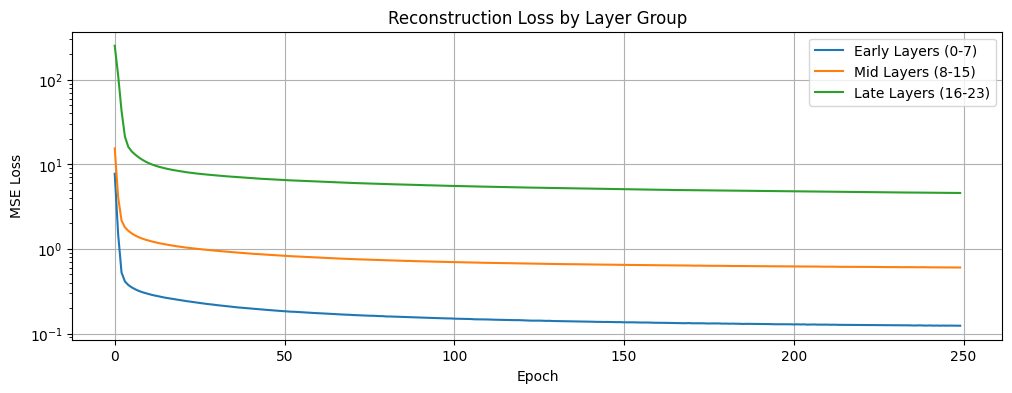

In [4]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i < 12:
        return 1
    else:
        return 2

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256, dropout_rate=0.1):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_mid, d_in),
            # No dropout before final output layer
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    indices = torch.randperm(acts.shape[0])
    shuffled_acts = acts[indices]
    
    losses = []
    n_batches = shuffled_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = shuffled_acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(250)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self, mlp):
        super().__init__()
        self.mlp = mlp

    def forward(self, x1, x2):
        h1 = self.mlp(x1)
        h2 = self.mlp(x2)
        return F.cosine_similarity(h1, h2, dim=-1)

class LayerwiseSiameseNetworks(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256):
        super().__init__()
        self.n_layers = n_layers
        self.layer_nets = nn.ModuleList([SiameseNetwork(encoders[i]) for i in range(n_layers)])

    def forward(self, x1, x2):
        similarities = []
        for layer in range(self.n_layers):
            net_at_layer = self.layer_nets[layer].cuda()
            # Get the activations at the given layer
            x1_l = x1[:, layer].cuda()
            x2_l = x2[:, layer].cuda()

            sim_at_layer = net_at_layer(x1_l, x2_l)
            # print(sim_at_layer.shape)
            similarities.append(sim_at_layer)

        return torch.stack(similarities, dim=-1)

class SimilarityLearner(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256, d_out_hidden=512, dropout=0.1):
        super().__init__()
        self.layer_nets = LayerwiseSiameseNetworks(encoders, n_layers, d_in, d_hidden)

        self.mlp = nn.Sequential(
            nn.Linear(n_layers, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, 1),
            nn.Hardsigmoid()
        )

    def forward(self, x1, x2, training=True):
        layerwise_similarities = self.layer_nets(x1, x2)
        similarity = self.mlp(layerwise_similarities)
        return similarity.squeeze()

In [6]:
from copy import deepcopy
cloned_encoders = [deepcopy(e).encode for e in encoders]

similarity_learner = SimilarityLearner(cloned_encoders, d_hidden=512).to('cuda:0')
# similarity_learner = SimilarityLearner([Autoencoder(i) for i in range(24)], d_hidden=512).to('cuda:0')
optimizer = torch.optim.Adam(similarity_learner.parameters(), lr=3e-5)

def train_epoch(model, first_acts, second_acts, scores, optimizer, batch_size=32):
    indices = torch.randperm(first_acts.shape[0])
    shuffled_first = first_acts[indices]
    shuffled_second = second_acts[indices]
    shuffled_scores = scores[indices]

    model.train()
    total_loss = 0
    n_batches = first_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        x1_batch = shuffled_first[start_idx:end_idx].cuda()
        x2_batch = shuffled_second[start_idx:end_idx].cuda()
        scores_batch = shuffled_scores[start_idx:end_idx].cuda()
        
        optimizer.zero_grad()
        
        sims = model(x1_batch, x2_batch)
        
        loss = F.mse_loss(sims, scores_batch)        
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches

best_test_corr = 0
best_model = None

for epoch in tqdm(range(150)):
    # Training
    loss = train_epoch(similarity_learner, first_train, second_train, train_scores, optimizer)
    
    # Evaluation
    similarity_learner.eval()
    with torch.no_grad():
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get training correlations
            train_preds = similarity_learner(first_train.cuda(), second_train.cuda(), training=False)
            train_corr = torch.corrcoef(torch.stack([train_preds.cpu(), train_scores]))[0,1]
            
            # Get test correlations
            test_preds = similarity_learner(first_test.cuda(), second_test.cuda(), training=False)
            test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]

            if test_corr > best_test_corr:
                best_test_corr = test_corr
                best_model = deepcopy(similarity_learner)

            print(f"Epoch {epoch+1}")
            print(f"Loss: {loss:.4f}")
            print(f"Train correlation: {train_corr:.4f}")
            print(f"Test correlation: {test_corr:.4f}\n")

  7%|███████████▋                                                                                                                                                                   | 10/150 [01:04<15:04,  6.46s/it]

Epoch 10
Loss: 0.0271
Train correlation: 0.8650
Test correlation: 0.6969



 13%|███████████████████████▎                                                                                                                                                       | 20/150 [02:13<15:06,  6.98s/it]

Epoch 20
Loss: 0.0165
Train correlation: 0.9273
Test correlation: 0.7299



 20%|███████████████████████████████████                                                                                                                                            | 30/150 [03:22<13:53,  6.95s/it]

Epoch 30
Loss: 0.0116
Train correlation: 0.9480
Test correlation: 0.7478



 27%|██████████████████████████████████████████████▋                                                                                                                                | 40/150 [04:30<12:07,  6.62s/it]

Epoch 40
Loss: 0.0088
Train correlation: 0.9646
Test correlation: 0.7429



 33%|██████████████████████████████████████████████████████████▎                                                                                                                    | 50/150 [05:39<11:36,  6.97s/it]

Epoch 50
Loss: 0.0072
Train correlation: 0.9725
Test correlation: 0.7454



 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 60/150 [06:48<10:16,  6.85s/it]

Epoch 60
Loss: 0.0059
Train correlation: 0.9784
Test correlation: 0.7468



 47%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 70/150 [07:57<09:14,  6.93s/it]

Epoch 70
Loss: 0.0047
Train correlation: 0.9821
Test correlation: 0.7492



 53%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 80/150 [09:06<08:08,  6.98s/it]

Epoch 80
Loss: 0.0040
Train correlation: 0.9800
Test correlation: 0.7521



 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 90/150 [10:14<06:52,  6.88s/it]

Epoch 90
Loss: 0.0034
Train correlation: 0.9867
Test correlation: 0.7472



 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 100/150 [11:21<05:34,  6.70s/it]

Epoch 100
Loss: 0.0031
Train correlation: 0.9868
Test correlation: 0.7469



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 110/150 [12:30<04:38,  6.97s/it]

Epoch 110
Loss: 0.0028
Train correlation: 0.9877
Test correlation: 0.7529



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 120/150 [13:40<03:27,  6.91s/it]

Epoch 120
Loss: 0.0026
Train correlation: 0.9892
Test correlation: 0.7514



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 130/150 [14:49<02:15,  6.77s/it]

Epoch 130
Loss: 0.0022
Train correlation: 0.9888
Test correlation: 0.7536



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 140/150 [15:57<01:09,  6.94s/it]

Epoch 140
Loss: 0.0021
Train correlation: 0.9902
Test correlation: 0.7514



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [17:07<00:00,  6.85s/it]

Epoch 150
Loss: 0.0019
Train correlation: 0.9919
Test correlation: 0.7512



In [7]:
test_preds = best_model(first_test.cuda(), second_test.cuda(), training=False)
test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]
print(test_corr)

tensor(0.7536, grad_fn=<SelectBackward0>)


In [8]:
param_count = sum([w.numel() for w in similarity_learner.parameters()])
f"This model has {param_count} parameters!"

'This model has 24606209 parameters!'